# Ch11. 텍스트 분류 (Text Classification)

# v06. 네이버 영화 리뷰 감성 분류하기 (Naver Movie Review Sentiment Analysis)

- 이번 챕터에서는 영어 데이터가 아닌 한국어/한글 데이터에 대해서 텍스트 분류를 수행해보자.
- 방법 자체는 영어 데이터에 대한 텍스트 분류와 크게 달라지지는 않았다.
- 다만 다른 점이 있다면 한국어 데이터는 토큰화(tokenization)를 할 때 형태소 분석기를 사용한다는 점이 다르다.
- 그 이유에 대해서는 2챕터의 토큰화 챕터를 참고하면 된다.

- 이번에 사용할 데이터는 네이버 영화 리뷰 데이터이다.
- 총 200,000개 리뷰로 구성된 데이터로 (앞서 실습한 IMDB 리뷰 데이터와 마찬가지로) 영화 리뷰에 대한 텍스트와 해당 리뷰가 긍정인 경우 1을 부정인 경우 0으로 표시한 레이블로 구성되어져 있다.

- 깃허브로부터 해당 데이터를 다운로드 받아 감성 분류를 수행하는 모델을 만들어보자.

<br>

## 6.1 네이버 영화 리뷰 데이터에 대한 이해와 전처리

- [다운로드 링크](https://github.com/e9t/nsmc/)

In [ ]:
!pip install konlpy

In [ ]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

<br>

### 6.1.1 데이터 로드하기

#### 6.1.1.1 데이터셋 로드

- 위의 링크로부터 훈련 데이터에 해당하는 `ratings_train.txt`와 테스트 데이터에 해당하는 `ratings_test.txt`를 다운로드한다.

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt",
                           filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt",
                           filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fa2c8736748>)

<br>

- 또한 Pandas를 이용하여 훈련 데이터는 `train_data`에 테스트 데이터는 `test_data`에 저장한다.

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

<br>

#### 6.1.1.2 훈련용 데이터셋 크기 확인

- `train_data`에 존재하는 영화 리뷰의 개수를 확인해보자.

In [5]:
print('훈련용 리뷰 개수 : ', len(train_data))

훈련용 리뷰 개수 :  150000


- `train_data`는 총 150,000개의 리뷰가 존재한다.

<br>

#### 6.1.1.3 훈련용 데이터셋 구성 확인

- `train_data`는 어떤 형태인 지 상위 5개만 출력해보자.

In [6]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


- 상위 5개의 샘플만 출력해봤는데, 해당 데이터는 `id`, `document`, `label` 총 3개의 열로 구성되어져 있다.
- `id`는 감성 분류를 수행하는데 도움이 되지 않으므로 앞으로 무시한다.
- 결국 이 모델은 리뷰 내용을 담고 있는 `document`와 해당 리뷰가 긍정(`1`), 부정(`0`)인지를 나타내는 `label` 두 개의 열을 학습하는 모델이 될 것이다.

- 여기서 한국어 데이터와 영어 데이터의 차이를 확인할 수 있다.
- 예를 들어, 인덱스 2에 해당하는 세번째 샘플은 띄어쓰기를 하지 않아도 글을 쉽게 이해할 수 있는 한국어의 특성으로 인해 띄어쓰기가 전혀 되어 있지 않다.

<br>

#### 6.1.1.4 테스트용 데이터셋 크기 확인

- 이제 `test_data`의 개수와 상위 5개 샘플을 확인해보자.

In [7]:
print('테스트용 리뷰 개수 : ', len(test_data))

테스트용 리뷰 개수 :  50000


- `test_data`는 총 50,000개의 영화 리뷰가 존재한다.

<br>

#### 6.1.1.5 테스트용 데이터셋 구성 확인

In [8]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


- `test_data`도 `train_data`와 동일한 형식으로 `id`, `document`, `label` 3개의 열로 구성되어 있다.
- `train_data`에 대한 전처리 과정을 정하고 나면, `test_data`에도 동일한 전처리 과정을 적용하면 될 것 같다.

<br>

### 6.1.2 데이터 정제하기

- 다시 `train_data`로 돌아가보자.

<br>

#### 6.1.2.1 중복 데이터 확인 및 제거

- 먼저 `train_data`에 중복된 데이터가 있는 지 확인해보자.

In [9]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

- 총 150,000개의 샘플이 존재하는 데 `document`열에서 중복을 제거한 샘플의 수가 146,182개라는 것은 약 4,000개의 중복 샘플이 존재한다는 의미이다.
- `label` 열은 0 또는 1의 값만을 가지므로 2가 출력되었다.

- 중복 샘플을 제거해보자.

In [ ]:
train_data.drop_duplicates(subset=['document'], inplace=True)

- 정말 중복 샘플이 제거되었는 지 전체 샘플 수를 확인해보자.

In [11]:
print('총 샘플의 수 : ', len(train_data))

총 샘플의 수 :  146183


- 중복 샘플이 제거되었다.

<br>

#### 6.1.2.2 레이블 값의 분포 확인

- `train_data`에서 해당 리뷰의 긍, 부정 유무가 기재되어 있는 레이블(label)값의 분포를 확인해보자.

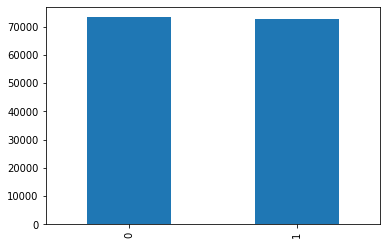

In [12]:
train_data['label'].value_counts().plot(kind='bar')

- 약 146,000개의 영화 리뷰 샘플이 존재하는 데 그래프 상으로 긍정과 부정 둘 다 약 72,000개의 샘플이 존재하여 레이블의 분포가 균일한 것처럼 보인다.

- 정확하게 몇 개인 지 확인하고 싶다면 아래의 코드를 수행하면 된다.

In [13]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  73342
1      1  72841


- 레이블이 0인 리뷰가 근소하게 많다.

<br>

#### 6.1.2.3 결측값 확인 및 제거

- 리뷰 중에 Null 값을 가진 샘플이 있는 지는 Pandas의 `isnull().values.any()`로 확인해보자.

In [14]:
print(train_data.isnull().values.any())

True


- `True`가 나왔다면 데이터 중에 Null 값을 가진 샘플이 존재한다는 의미이다.

- 어떤 열에 존재하는 지 확인해보자.

In [15]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


- 리뷰가 적혀있는 `document` 열에서 Null 값을 가진 샘플이 총 1개가 존재한다고 한다.
- 그렇다면 `document` 열에서 Null 값이 존재한다는 것을 조건으로 Null 값을 가진 샘플이 어느 인덱스의 위치에 존재하는 지 한번 출력해보자.

In [16]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


- Null 값을 가진 샘플을 제거해보자.

In [17]:
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


- Null 값을 가진 샘플이 제거되었다.

- 다시 샘플의 개수를 출력하여 1개의 샘플이 제거되었는 지 확인해보자.

In [18]:
print(len(train_data))

146182


<br>

####6.1.2.4 정규 표현식 활용 데이터 전처리

- 이제 데이터의 전처리를 수행해보자.
- 위의 `train_data`와 `test_data`에서 온점(.)이나 물음표(?)와 같은 각종 특수문자가 사용된 것을 확인했다.
- `train_data`로부터 한글만 남기고 제거하기 위해서 정규 표현식을 사용해보자.

- 우선 한글이 아니라 영어의 경우를 상기해보자.
- 영어의 알파벳들을 나타내는 정규 표현식은 `[a-zA-Z]`이다.
- 이 정규 표현식은 영어의 소문자와 대문자들을 모두 포함하고 있는 정규 표현식이다.
- 이를 응용하면 영어에 속하지 않는 구두점이나 특수 문자를 제거할 수 있다.
- 예를 들어 알파벳과 공백을 제외하고 모두 제거하는 전처리를 수행하는 예제는 다음과 같다.

In [19]:
text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'

re.sub(r'[^a-zA-Z ]', '', text)

'do you expect people to read the FAQ etc and actually accept hard atheism'

<br>

- 위와 같은 원리를 한국어 데이터에 적용하고 싶다면, 우선 한글을 범위 지정할 수 있는 정규 표현식을 찾아내면 된다.
- 우선 자음과 모음의 대한 범위를 지정해보자.
- 일반적으로 자음의 범위는 `ㄱ ~ ㅎ`, 모음의 범위는 `ㅏ ~ ㅣ`와 같이 지정할 수 있다.
- 해당 범위 내에 어떤 자음과 모음이 속하는 지 알고 싶다면 [해당 링크](https://www.unicode.org/charts/PDF/U3130.pdf)를 참고하면 된다.
  - `ㄱ ~ ㅎ` : `3131` ~ `314E`
  - `ㅏ ~ ㅣ` : `314F` ~ `3163`

- 또한 완성형 한글의 범위는 `가 ~ 힣`과 같이 사용한다.
- 해당 범위 내에 포함된 음절들은 [해당 링크](https://www.unicode.org/charts/PDF/UAC00.pdf)에서 확인할 수 있다.

<br>

- 위의 범위 지정을 모두 반영하여 `train_data`에 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행해보자.

In [20]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")

In [22]:
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


- 상위 5개의 샘플을 다시 출력해보았는데, 정규 표현식을 수행하자 기존의 공백. 즉, 띄어쓰기는 유지되면서 온점과 같은 구두점 등은 제거되었다.
- 그런데 사실 네이버 영화 리뷰는 굳이 한글이 아니라 영어, 숫자, 특수문자로도 리뷰를 업로드할 수 있다.
- 다시 말해 기존에 한글이 없는 리뷰였다면 이제 더 이상 아무런 값도 없는 빈(empty)값이 되었을 것이다.

- `train_data`에 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, 다시 한번 Null 값이 존재하는 지 확인해보자.

In [23]:
train_data['document'].replace('', np.nan, inplace=True)
print(train_data['document'].isnull().sum())

391


- Null 값이 391개나 새로 생겼다.

- Null 값이 있는 행을 5개만 출력해보자.

In [24]:
train_data.loc[train_data['document'].isnull()][:5]

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1


- Null 샘플들은 레이블이 긍정일 수도 있고, 부정일 수도 있다.
- 사실 아무런 의미도 없는 데이터므로 제거해준다.

In [25]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145791


- 샘플 개수가 또 다시 줄어서 이제 145,791개가 남았다.

<br>

#### 6.1.2.5 테스트 데이터 전처리

- 테스트 데이터에 지금까지 진행했던 전처리 과정들을 동일하게 진행한다.

In [26]:
# document 열에서 중복인 내용이 있다면 중복 제거
test_data.drop_duplicates(subset=['document'], inplace=True)

# 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")

# 공백은 Null 값으로 변경
test_data['document'].replace('', np.nan, inplace=True)

# Null 값 제거
test_data = test_data.dropna(how='any')

print('전처리 후 테스트용 샘플의 개수 : ', len(test_data))

전처리 후 테스트용 샘플의 개수 :  48995


<br>

### 6.1.3 토큰화

- 이제 토큰화를 해보자.

<br>

#### 6.1.3.1 불용어 정의

- 토큰화 과정에서 불용어를 제거한다.
- 불용어는 정의하기 나름이지만, 한국어의 조사, 접속사 등의 보편적인 불용어를 사용할 수 있다.
- 하지만 결국 풀고자 하는 문제의 데이터를 지속적으로 검토하면서 계속해서 추가하는 경우 또한 많다.
- 실제 현업인 상황이라면 일반적으로 아래의 불용어보다 더 많은 불용어를 사용하기도 한다.

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

- 여기서는 위 정도로만 불용어를 정의한다.

<br>

#### 6.1.3.2 형태소 분석기 `Okt`

- 토큰화를 위한 형태소 분석기는 KoNLPy의 `Okt`를 사용한다.
- 잠시 `Okt`를 복습해보자.

In [28]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔',
           stem=True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

- `Okt`는 위와 같이 KoNLPy에서 제공하는 형태소 분석기이다.
- 한국어를 토큰화할 때는 영어처럼 띄어쓰기 기준으로 토큰화를 하는 것이 아니라, 주로 형태소 분석기를 사용한다.
- `stem=True`를 사용하면 일정 수준의 정규화를 수행해준다.
  - 예를 들어 위의 예제의 결과를 보면 '이런'이 '이렇다'로 변환됨
  - '만드는'이 '만들다'로 변환됨

<br>

#### 6.1.3.3 토큰화 및 불용어 제거

- 이제 `train_data`에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 `X_train`에 저장한다.

In [ ]:
X_train = []

for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [30]:
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


<br>

#### 6.1.3.4 테스트 데이터 토큰화 및 불용어 제거

In [ ]:
X_test = []

for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_test.append(temp_X)

In [32]:
print(X_test[:3])

[['굳다', 'ㅋ'], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]


<br>

### 6.1.4 정수 인코딩